<a href="https://colab.research.google.com/github/amirularsyad/MachineLearningCourse_HW_TelU/blob/main/12thWeek/CNN_German_Traffic_Sign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')
# Membaca file CSV nama-nama rambu lalu lintas Jerman
sign_name_df = pd.read_csv('/content/drive/MyDrive/Dataset/signname.csv')

# Memasukkan nilai-nilai pada kolom 'SignName' ke dalam array SIGN_NAMES
SIGN_NAMES = sign_name_df.SignName.values

# Mengatur indeks DataFrame ke kolom 'ClassId'
sign_name_df.set_index('ClassId', inplace=True)

# Menampilkan 10 baris pertama dari DataFrame
sign_name_df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [7]:
# Path ke file data latih
training_file = "/content/drive/MyDrive/Dataset/train.p"

# Path ke file data uji
testing_file = "/content/drive/MyDrive/Dataset/test.p"

# Buka file data latih dalam mode biner
with open(training_file, mode='rb') as f:
    # Muat isi file data latih dengan modul pickle
    train = pickle.load(f)

# Buka file data uji dalam mode biner
with open(testing_file, mode='rb') as f:
    # Muat isi file data uji dengan modul pickle
    test = pickle.load(f)

# Cetak teks data berhasil dimuat
print("Data dimuat")

Data dimuat


In [8]:
# Mengatur gaya visualisasi menggunakan ggplot style dari matplotlib
matplotlib.style.use('ggplot')

# Mengaktifkan visualisasi inline di dalam notebook
%matplotlib inline

# Mengatur format gambar agar lebih tajam (retina)
%config InlineBackend.figure_format = 'retina'

In [9]:
# Mendefinisikan fitur (features) dan label untuk data latih
X, y = train['features'], train['labels']

# Mengonversi list ke dalam array numpy
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# Mendefinisikan fitur (features) dan label untuk data uji
X_test, y_test = test['features'], test['labels']

# Mengonversi list ke dalam array numpy
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


In [10]:
# Mengambil data uji (X_test) dan label uji (y_test) dari suatu objek atau variabel bernama 'test'
X_test, y_test = test['features'], test['labels']

In [11]:
# Evaluasi model pada data uji
X_test = np.array(X_test)
y_test = np.array(y_test)

# Mencetak hasil evaluasi
print(X_test.shape, y_test.shape)

(12630, 32, 32, 3) (12630,)


In [12]:
# Menggunakan train_test_split untuk membagi data menjadi set pelatihan dan set validasi
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)

# Mencetak dimensi (shape) dari set pelatihan dan set validasi
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


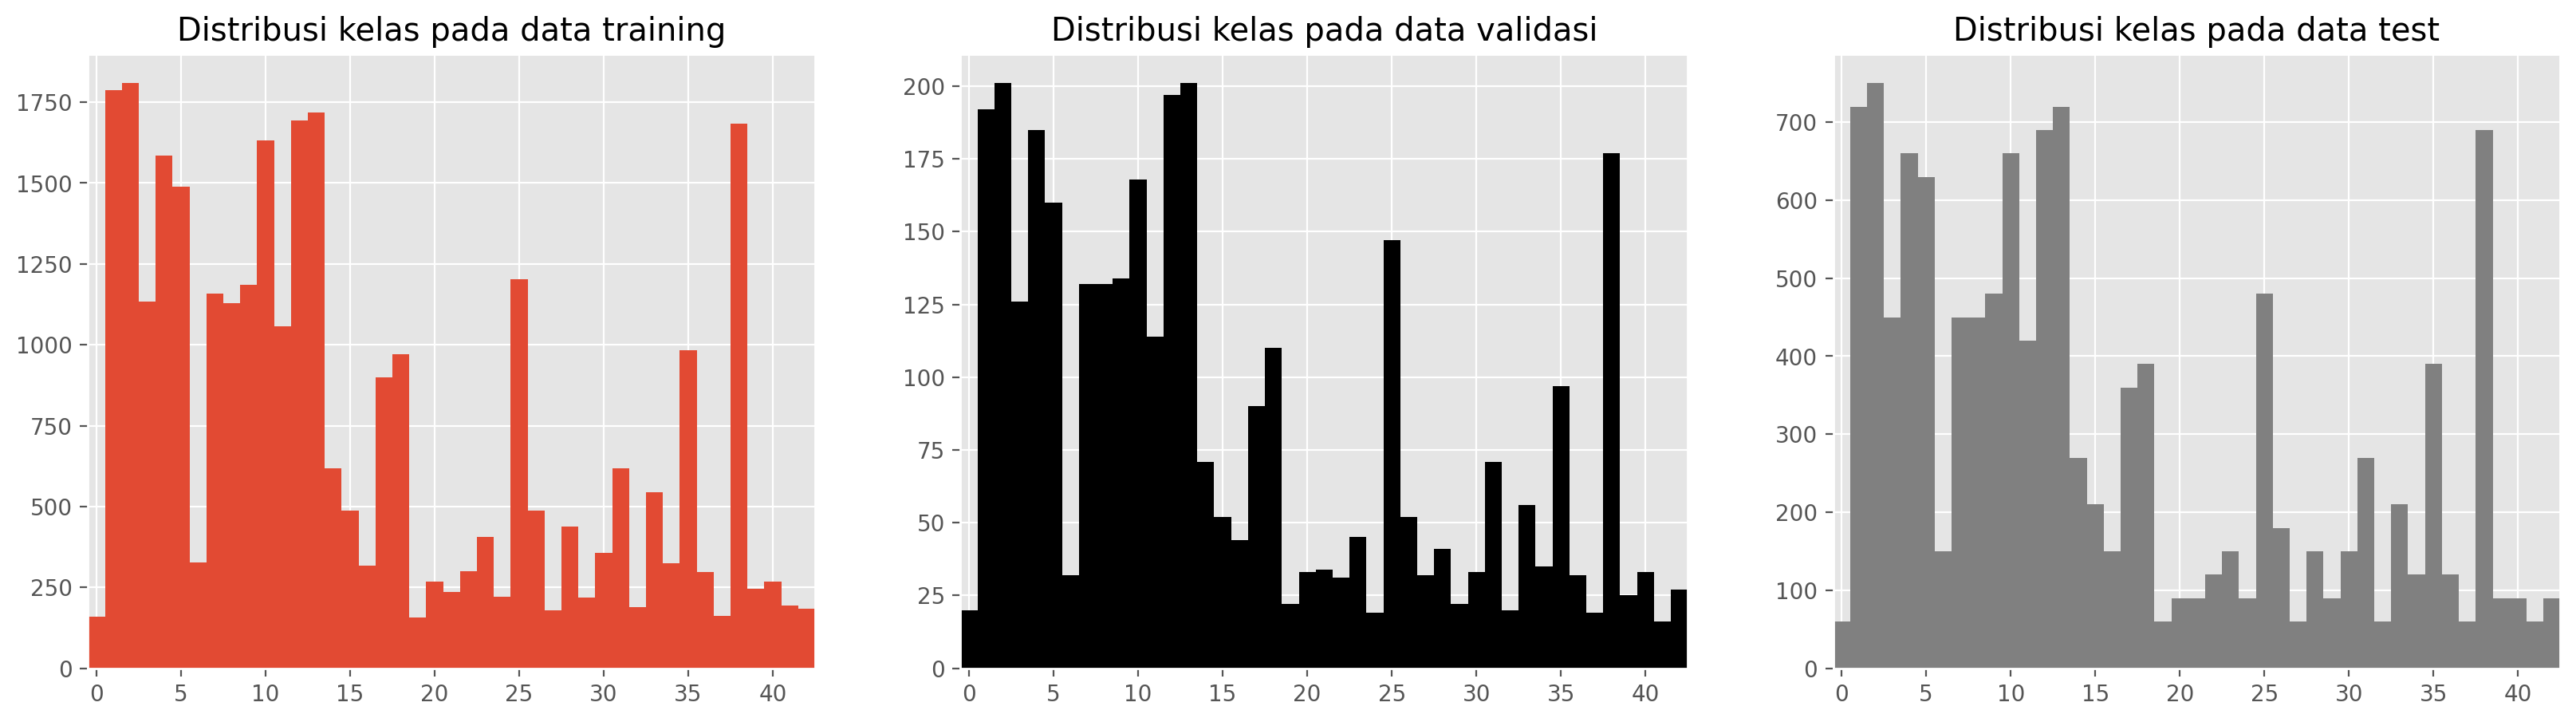

In [13]:
# Mendapatkan jumlah unik kelas pada data pelatihan
n_labels = np.unique(y_train).size

# Fungsi untuk membuat histogram distribusi kelas
def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs:
        ax.legend()
    if title:
        ax.set_title(title)

# Membuat subplot untuk menampilkan histogram distribusi kelas pada data pelatihan, validasi, dan uji
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Menampilkan histogram distribusi kelas pada data pelatihan
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])

# Menampilkan histogram distribusi kelas pada data validasi
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')

# Menampilkan histogram distribusi kelas pada data uji
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

In [14]:
from tensorflow.keras.utils import to_categorical

# Mengonversi label kelas menjadi representasi one-hot encoding
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [15]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
            # Menghentikan pelatihan jika akurasi melebihi 96%
            if(logs.get('accuracy') > 0.96):
              print("\nAkurasi telah mencapai >96%. Stop training!")
              self.model.stop_training = True

# Membuat instance dari kelas myCallback sebagai callbacks
callbacks = myCallback()

In [16]:
# Inisialisasi model Sequential
model = Sequential()

# Layer konvolusi pertama dengan 32 filter, ukuran kernel 5x5, aktivasi ReLU, dan input shape sesuai dengan dimensi data
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=X_train.shape[1:]))

# Layer konvolusi kedua dengan 32 filter, ukuran kernel 5x5, dan aktivasi ReLU
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))

# Layer pooling menggunakan MaxPooling dengan pool size 2x2
model.add(MaxPool2D(pool_size=(2, 2)))

# Layer dropout untuk mengurangi overfitting dengan tingkat dropout 25%
model.add(Dropout(rate=0.25))

# Layer konvolusi ketiga dengan 64 filter, ukuran kernel 3x3, dan aktivasi ReLU
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Layer konvolusi keempat dengan 64 filter, ukuran kernel 3x3, dan aktivasi ReLU
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Layer pooling menggunakan MaxPooling dengan pool size 2x2
model.add(MaxPool2D(pool_size=(2, 2)))

# Layer dropout untuk mengurangi overfitting dengan tingkat dropout 25%
model.add(Dropout(0.25))

# Meratakan (flatten) output untuk dimasukkan ke dalam layer Dense
model.add(Flatten())

# Layer Dense (fully connected) dengan 256 neuron dan aktivasi ReLU
model.add(Dense(256, activation='relu'))

# Layer dropout untuk mengurangi overfitting dengan tingkat dropout 50%
model.add(Dropout(0.5))

# Layer output dengan 43 neuron (sesuai dengan jumlah kelas) dan aktivasi softmax
model.add(Dense(43, activation='softmax'))

In [18]:
#Memberikan gambaran ringkas tentang arsitektur model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [19]:
#Mengonfigurasi proses pelatihan pada model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# Mengatur jumlah epoch
epochs = 25

# Melatih model dengan menggunakan data pelatihan dan validasi
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/25
979/979 [==============================] - 146s 147ms/step - loss: 1.9008 - accuracy: 0.5029 - val_loss: 0.5551 - val_accuracy: 0.8647
Epoch 2/25
979/979 [==============================] - 141s 144ms/step - loss: 0.7981 - accuracy: 0.7576 - val_loss: 0.2978 - val_accuracy: 0.9256
Epoch 3/25
979/979 [==============================] - 133s 135ms/step - loss: 0.6105 - accuracy: 0.8142 - val_loss: 0.2637 - val_accuracy: 0.9322
Epoch 4/25
979/979 [==============================] - 134s 137ms/step - loss: 0.5313 - accuracy: 0.8382 - val_loss: 0.2130 - val_accuracy: 0.9471
Epoch 5/25
979/979 [==============================] - 133s 135ms/step - loss: 0.4695 - accuracy: 0.8541 - val_loss: 0.1495 - val_accuracy: 0.9598
Epoch 6/25
979/979 [==============================] - 138s 141ms/step - loss: 0.4353 - accuracy: 0.8671 - val_loss: 0.1535 - val_accuracy: 0.9621
Epoch 7/25
979/979 [==============================] - 132s 135ms/step - loss: 0.4102 - accuracy: 0.8743 - val_loss: 0.1379 -

In [23]:
#Menyimpan model neural network yang telah dilatih ke file dengan format HDF5
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


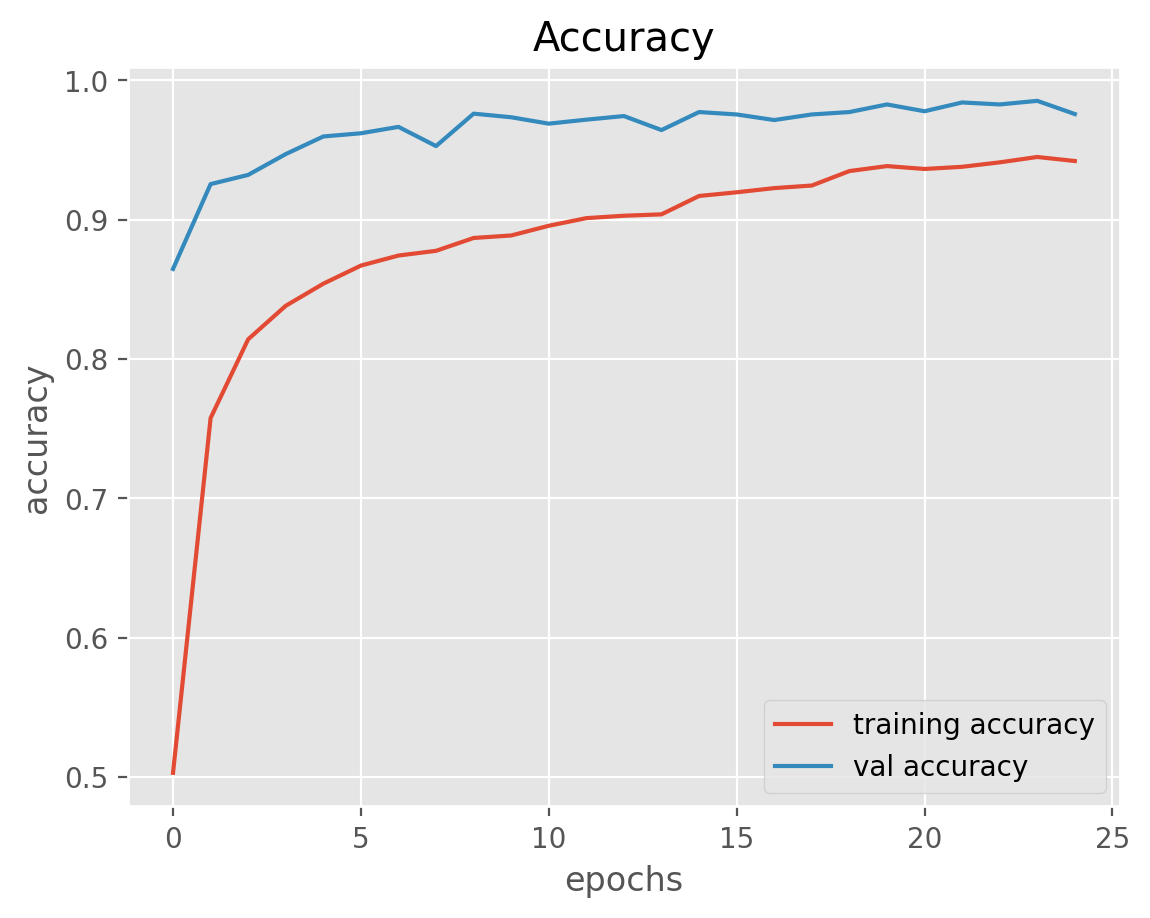

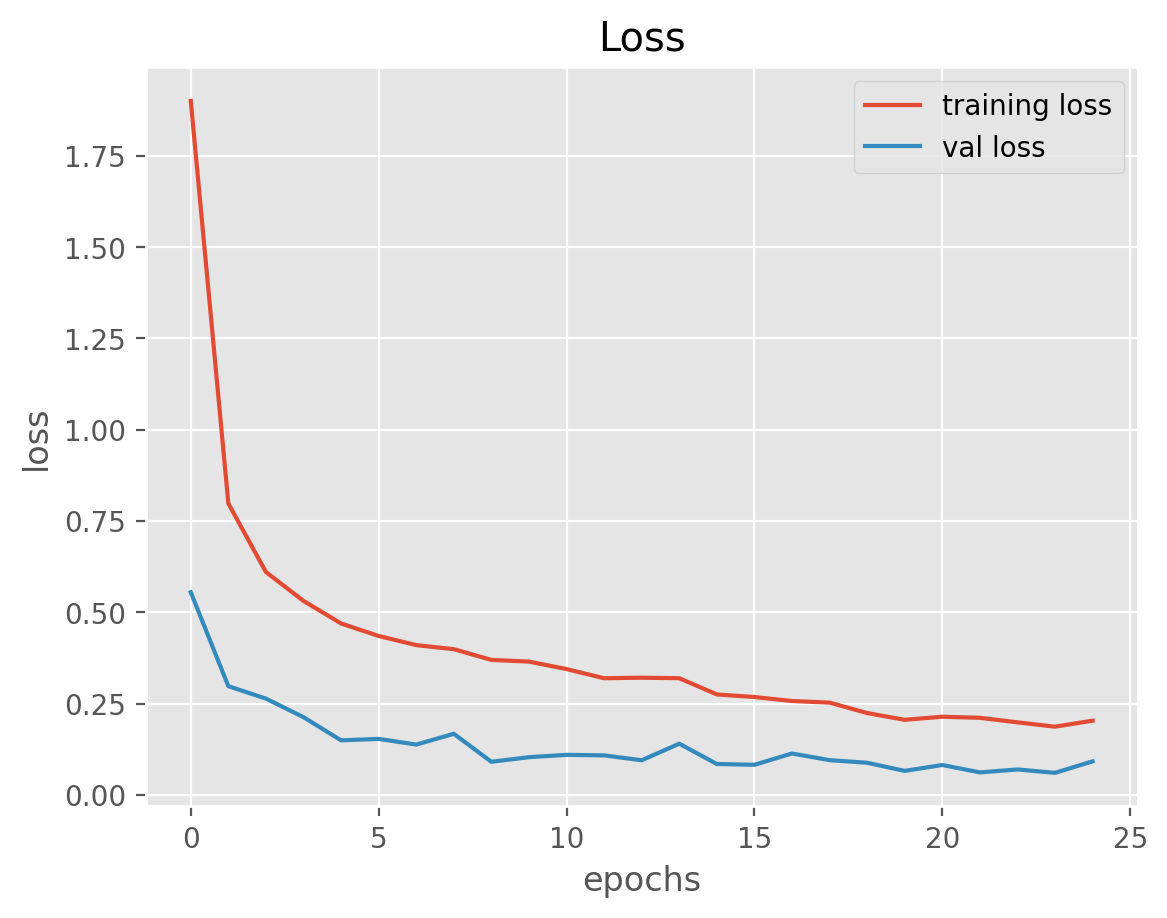

In [24]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')  # Judul plot untuk akurasi
plt.xlabel('epochs')    # Label sumbu x: epochs (epoch training)
plt.ylabel('accuracy')  # Label sumbu y: nilai akurasi
plt.legend()            # Menampilkan legenda
plt.show()              # Menampilkan plot

# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')      # Judul plot untuk loss
plt.xlabel('epochs')    # Label sumbu x: epochs (epoch training)
plt.ylabel('loss')      # Label sumbu y: nilai loss
plt.legend()            # Menampilkan legenda
plt.show()              # Menampilkan plot

In [25]:
# Import modul accuracy_score dari sklearn.metrics
from sklearn.metrics import accuracy_score

# Melakukan prediksi menggunakan model pada data uji (X_test)
pred = np.argmax(model.predict(X_test), axis=-1)

# Menghitung nilai akurasi dengan membandingkan label sebenarnya (y_test) dengan hasil prediksi (pred)
accuracy_score(y_test, pred)

395/395 [==============================] - 17s 43ms/step


0.9220110847189232

In [26]:
from sklearn.metrics import classification_report

In [27]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.63      0.76        60
           1       0.93      0.96      0.94       720
           2       0.92      0.93      0.92       750
           3       0.85      0.95      0.90       450
           4       0.90      0.96      0.93       660
           5       0.89      0.93      0.91       630
           6       0.99      0.81      0.89       150
           7       0.93      0.98      0.96       450
           8       0.97      0.89      0.93       450
           9       0.93      0.95      0.94       480
          10       0.99      0.97      0.98       660
          11       0.96      0.92      0.94       420
          12       0.96      0.92      0.94       690
          13       0.96      1.00      0.98       720
          14       0.98      0.91      0.94       270
          15       0.98      0.83      0.90       210
          16       0.99      0.98      0.98       150
          17       0.99    